# Exploring singlepoint

In [7]:
# improts
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import re
from pathlib import Path
from glob import glob
import pickle
import shutil
import json
import io
import pandas as pd
import seaborn as sns
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
import py3Dmol

# For highlight colors
from matplotlib.colors import ColorConverter

from ipywidgets import interact,fixed,IntSlider


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Utility functions from nitrogenase module
sys.path.insert(0, '/home/magstr/Documents/nitrogenase/niflheim_scripts/nitrogenase/backup_plot_diagram')
from data_handler import get_energies, get_paths, get_energy_dicts, read_properties_sp
from data_handler import renamed_load, extract_scoring3,extract_scoring2, extract_scoring1
    
# Custom functions 
from my_utils.analysis import draw_generation,conf_viewer, natural_keys, atoi
from my_utils.classes import Generation

#IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 500,500
IPythonConsole.drawOptions.addAtomIndices = True

font = {'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)


dft_base = Path('/home/magstr/dft_data')

HARTREE2EV = 27.2114
HARTREE2KCAL = 627.51
kcal = 627.51
ev = 27.2114

In [8]:
# Scoring function dict
funcs = {
        "rdkit_embed_scoring": extract_scoring1,
        "rdkit_embed_scoring_NH3toN2": extract_scoring2,
        "rdkit_embed_scoring_NH3plustoNH3": extract_scoring3,
    }

## Load the reference energies

In [9]:
(
        reactions_gfn1_corrected,
        reactions_gfn2_corrected,
        reactions_dft_ams_tzp,
        reactions_dft_orca_tzp,
        reactions_dft_orca_svp_tzp,
        reactions_dft_orca_sarcJ_tzp
    ) = get_energy_dicts()

In [10]:
reactions_dft_orca_tzp

{'N2': -68745.86604206839,
 'LuH+': -205372.4092126641,
 'Lu': -205110.45920451736,
 'H2': -731.7751548361912,
 'CrCp2+': -1150967.7260743862,
 'NH3': -35493.542519196264,
 'CrCp2': -1151066.3300395126,
 'delta_Cp': 98.60396512644365,
 'delta_Lu': 261.95000814672676}

In [11]:
reactions_dft_orca_sarcJ_tzp

{'N2': -68745.84023173494,
 'LuH+': -205372.22587124197,
 'Lu': -205110.28921852674,
 'H2': -731.7124100077522,
 'CrCp2+': -1150965.872722023,
 'NH3': -35493.47005100311,
 'CrCp2': -1151064.3911246804,
 'delta_Cp': 98.5184026574716,
 'delta_Lu': 261.9366527152306}

In [12]:
delta = (N2 * kcal + reactions_dft_orca_sarcJ_tzp["NH3"]) - (
                    NH3 * kcal + reactions_dft_orca_sarcJ_tzp["N2"]
                )

NameError: name 'N2' is not defined

In [13]:
# Here i hardtested the discrepancy in the two basis sets. 

N2=-5361.363
NH3=-5308.333
print(f'Without def2/j: Delta = {N2*kcal + reactions_dft_orca_sarcJ_tzp["NH3"] - (NH3*kcal + reactions_dft_orca_sarcJ_tzp["N2"])}')
      
N2=-5525.381
NH3=-5472.404
print(f'With def2/j: Delta = {N2*kcal + reactions_dft_orca_tzp["NH3"] - (NH3*kcal + reactions_dft_orca_tzp["N2"])}')
      

Without def2/j: Delta = -24.48511926876381
With def2/j: Delta = 8.72625287156552


# Singlepoint from GA analysis (before ind was saved)

# Singlepoint from GA analysis multiple

In [14]:
# Reference paths: 
# For comparing the dej2 and nodef2 results
# Path('/home/magstr/dft_data/prod_new12_0_def2j'),Path('/home/magstr/dft_data/prod_new12_0')

### Standard comparing all in same plot

In [15]:
logfiles = [dft_base / 'prod_new12_0_def2j',dft_base/'prod_new12_0']

deltas for f1:[-27.36979779601097, 9.109238354954869, -16.278877740260214, -13.469309360720217, -19.443520955741405, -8.75476889172569, -4.832387011963874, -8.386091005057096, -6.344896127469838, -13.745473810005933, -14.547073795460165, -12.945104223210365, -7.833231357391924, -21.75296216038987, -25.37571768788621]


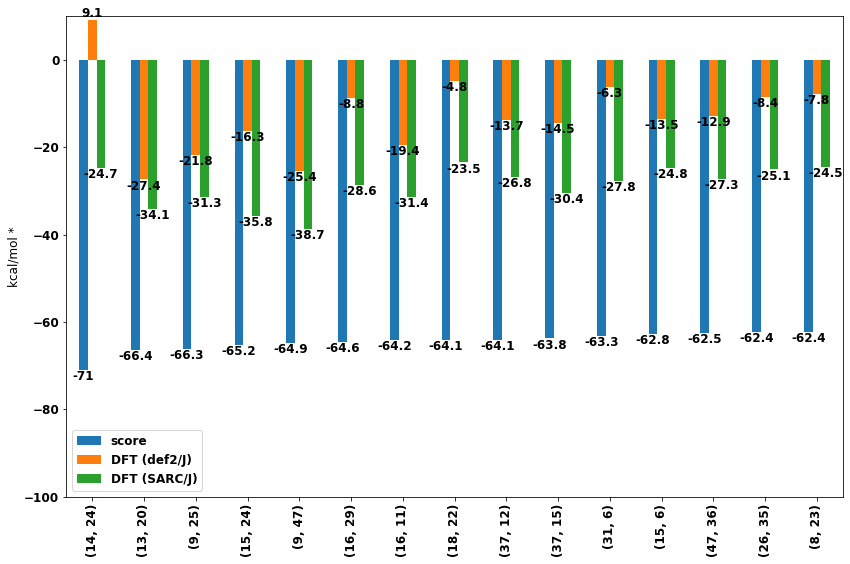

In [22]:
fig, ax = plt.subplots(figsize=(12, 8))

file = logfiles[0]

f1 = sorted(logfiles[0].glob('*[!.csv]'))
f2 = sorted(logfiles[1].glob('*[!.csv]'))

# Get the scoring funtion that was used
if sorted(file.glob('*/Mo_NH3+')):
    scoring = 'rdkit_embed_scoring_NH3plustoNH3'
elif sorted(file.glob('*/Mo_N2_NH3')):
    scoring = 'rdkit_embed_scoring'
    print('setting rkdit_embed_scoring')
elif sorted(file.glob('*/Mo_N2')):
    scoring = 'rdkit_embed_scoring_NH3toN2'


inds,deltas = funcs[scoring](f1)
inds2,deltas2 = funcs[scoring](f2)
print(f'deltas for f1:{deltas}')


gen = Generation(molecules=inds)
df = gen.gen2pd()
df['DFT'] = deltas
df['DFT2'] = deltas2
df['score'] = df['score'].apply(lambda x: round(x, 1))
df['DFT'] = df['DFT'].apply(lambda x: round(x, 1))
df['DFT2'] = df['DFT2'].apply(lambda x: round(x, 1))
df.sort_values(by=['score'], inplace=True)

# Save DF
#df.to_csv(dataframe_path)
# Scoring function dict
df[['score','DFT', 'DFT2']].plot.bar(ax=ax);
ax.set(ylabel='kcal/mol *',ylim=(-100,10),xlabel='')
ax.legend(['score','DFT (def2/J)', 'DFT (SARC/J)'])
#ax.set_xticks([f'Molecule {x}' for x in range(5)])
for container in ax.containers:
    ax.bar_label(container)
fig.tight_layout()

fig.savefig('img.png',dpi=600)

### 

### One plot for each

In [34]:
logfiles = [dft_base/'prod_new24_1score_large_0',dft_base/'prod_new23_1score_large_0',dft_base/'prod_new25_2score_large_0',dft_base/'prod_new12_0',dft_base/'prod_new20_large_0',dft_base/'prod_new19_large_0']
num_plots = len(logfiles)

/home/magstr/dft_data/prod_new24_1score_large_0
setting rkdit_embed_scoring
/home/magstr/dft_data/prod_new23_1score_large_0
setting rkdit_embed_scoring
/home/magstr/dft_data/prod_new25_2score_large_0
/home/magstr/dft_data/prod_new12_0
/home/magstr/dft_data/prod_new20_large_0
/home/magstr/dft_data/prod_new19_large_0


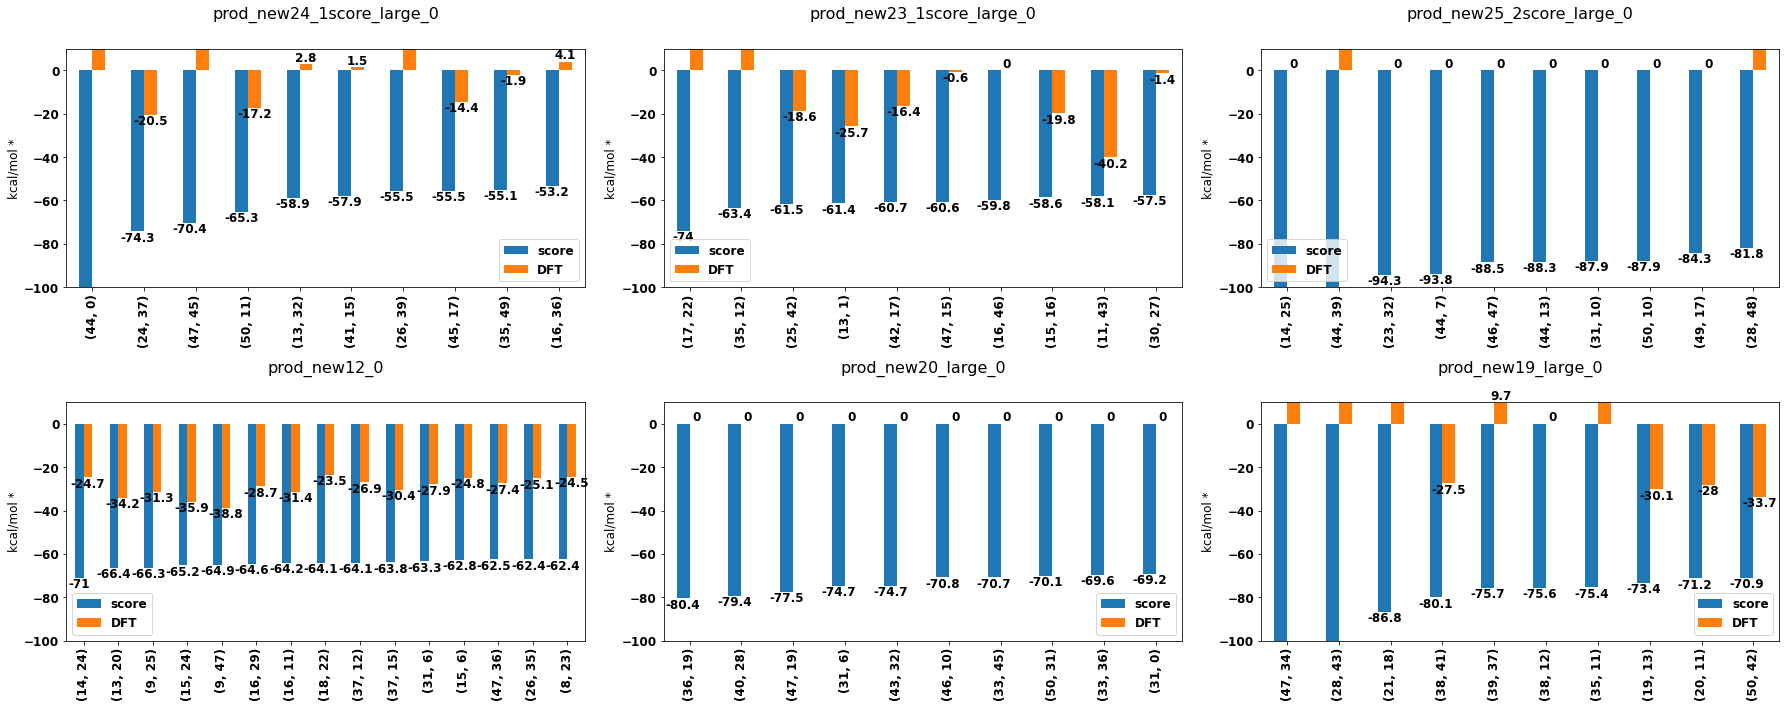

In [35]:
# Init figure
fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(25, 10));
ax = ax.flatten()

for i,file in enumerate(logfiles):
    print(file)
    ax_i=ax[i]
    
    # Get the scoring funtion that was used
    if sorted(file.glob('*/Mo_NH3+')):
        scoring = 'rdkit_embed_scoring_NH3plustoNH3'
    elif sorted(file.glob('*/Mo_N2_NH3')):
        scoring = 'rdkit_embed_scoring'
        print('setting rkdit_embed_scoring')
    elif sorted(file.glob('*/Mo_N2')):
        scoring = 'rdkit_embed_scoring_NH3toN2'

        
    f = sorted(file.glob('*[!.csv]'))
    dataframe_path = f[0].parent /'df.csv'
    
    # Delete csv and redo scoring
    #if dataframe_path.is_file():
    #    dataframe_path.unlink()
    
    if dataframe_path.is_file():
        df = pd.read_csv(dataframe_path, index_col=[0,1])
    else:
        print(scoring)
        inds,deltas = funcs[scoring](f)
        
        gen = Generation(molecules=inds)
        df = gen.gen2pd()
        df['DFT'] = deltas
        df['score'] = df['score'].apply(lambda x: round(x, 1))
        df['DFT'] = df['DFT'].apply(lambda x: round(x, 1))
        df.sort_values(by=['score'], inplace=True)
        
        # Save DF
        df.to_csv(dataframe_path)
        
    df[['score','DFT']].plot.bar(ax=ax_i);
    ax_i.set(ylabel='kcal/mol *',ylim=(-100,10), xlabel='')
    ax_i.set_title(f[0].parent.name,fontsize = 16, pad=30)
    #ax.set_xticks([f'Molecule {x}' for x in range(5)])
    for container in ax_i.containers:
        ax_i.bar_label(container)
fig.tight_layout()

## Bar and correlation plots

In [39]:
logfiles = [dft_base/'prod_new15_large_0', dft_base/'prod_new16_large_0', dft_base/'prod_new17_large_0', dft_base/'prod_new18_large_0', dft_base/'prod_new19_large_0',\
            dft_base/'prod_new20_large_0', dft_base/'prod_new21_large_0', dft_base/'prod_new22_large_0', dft_base/'prod_new23_1score_large_0', dft_base/'prod_new24_1score_large_0',\
           dft_base/'prod_new25_2score_large_0']
num_plots = len(logfiles)

/home/magstr/dft_data/prod_new15_large_0
/home/magstr/dft_data/prod_new16_large_0
/home/magstr/dft_data/prod_new17_large_0
/home/magstr/dft_data/prod_new18_large_0
/home/magstr/dft_data/prod_new19_large_0
/home/magstr/dft_data/prod_new20_large_0
/home/magstr/dft_data/prod_new21_large_0
/home/magstr/dft_data/prod_new22_large_0
/home/magstr/dft_data/prod_new23_1score_large_0
/home/magstr/dft_data/prod_new24_1score_large_0
/home/magstr/dft_data/prod_new25_2score_large_0


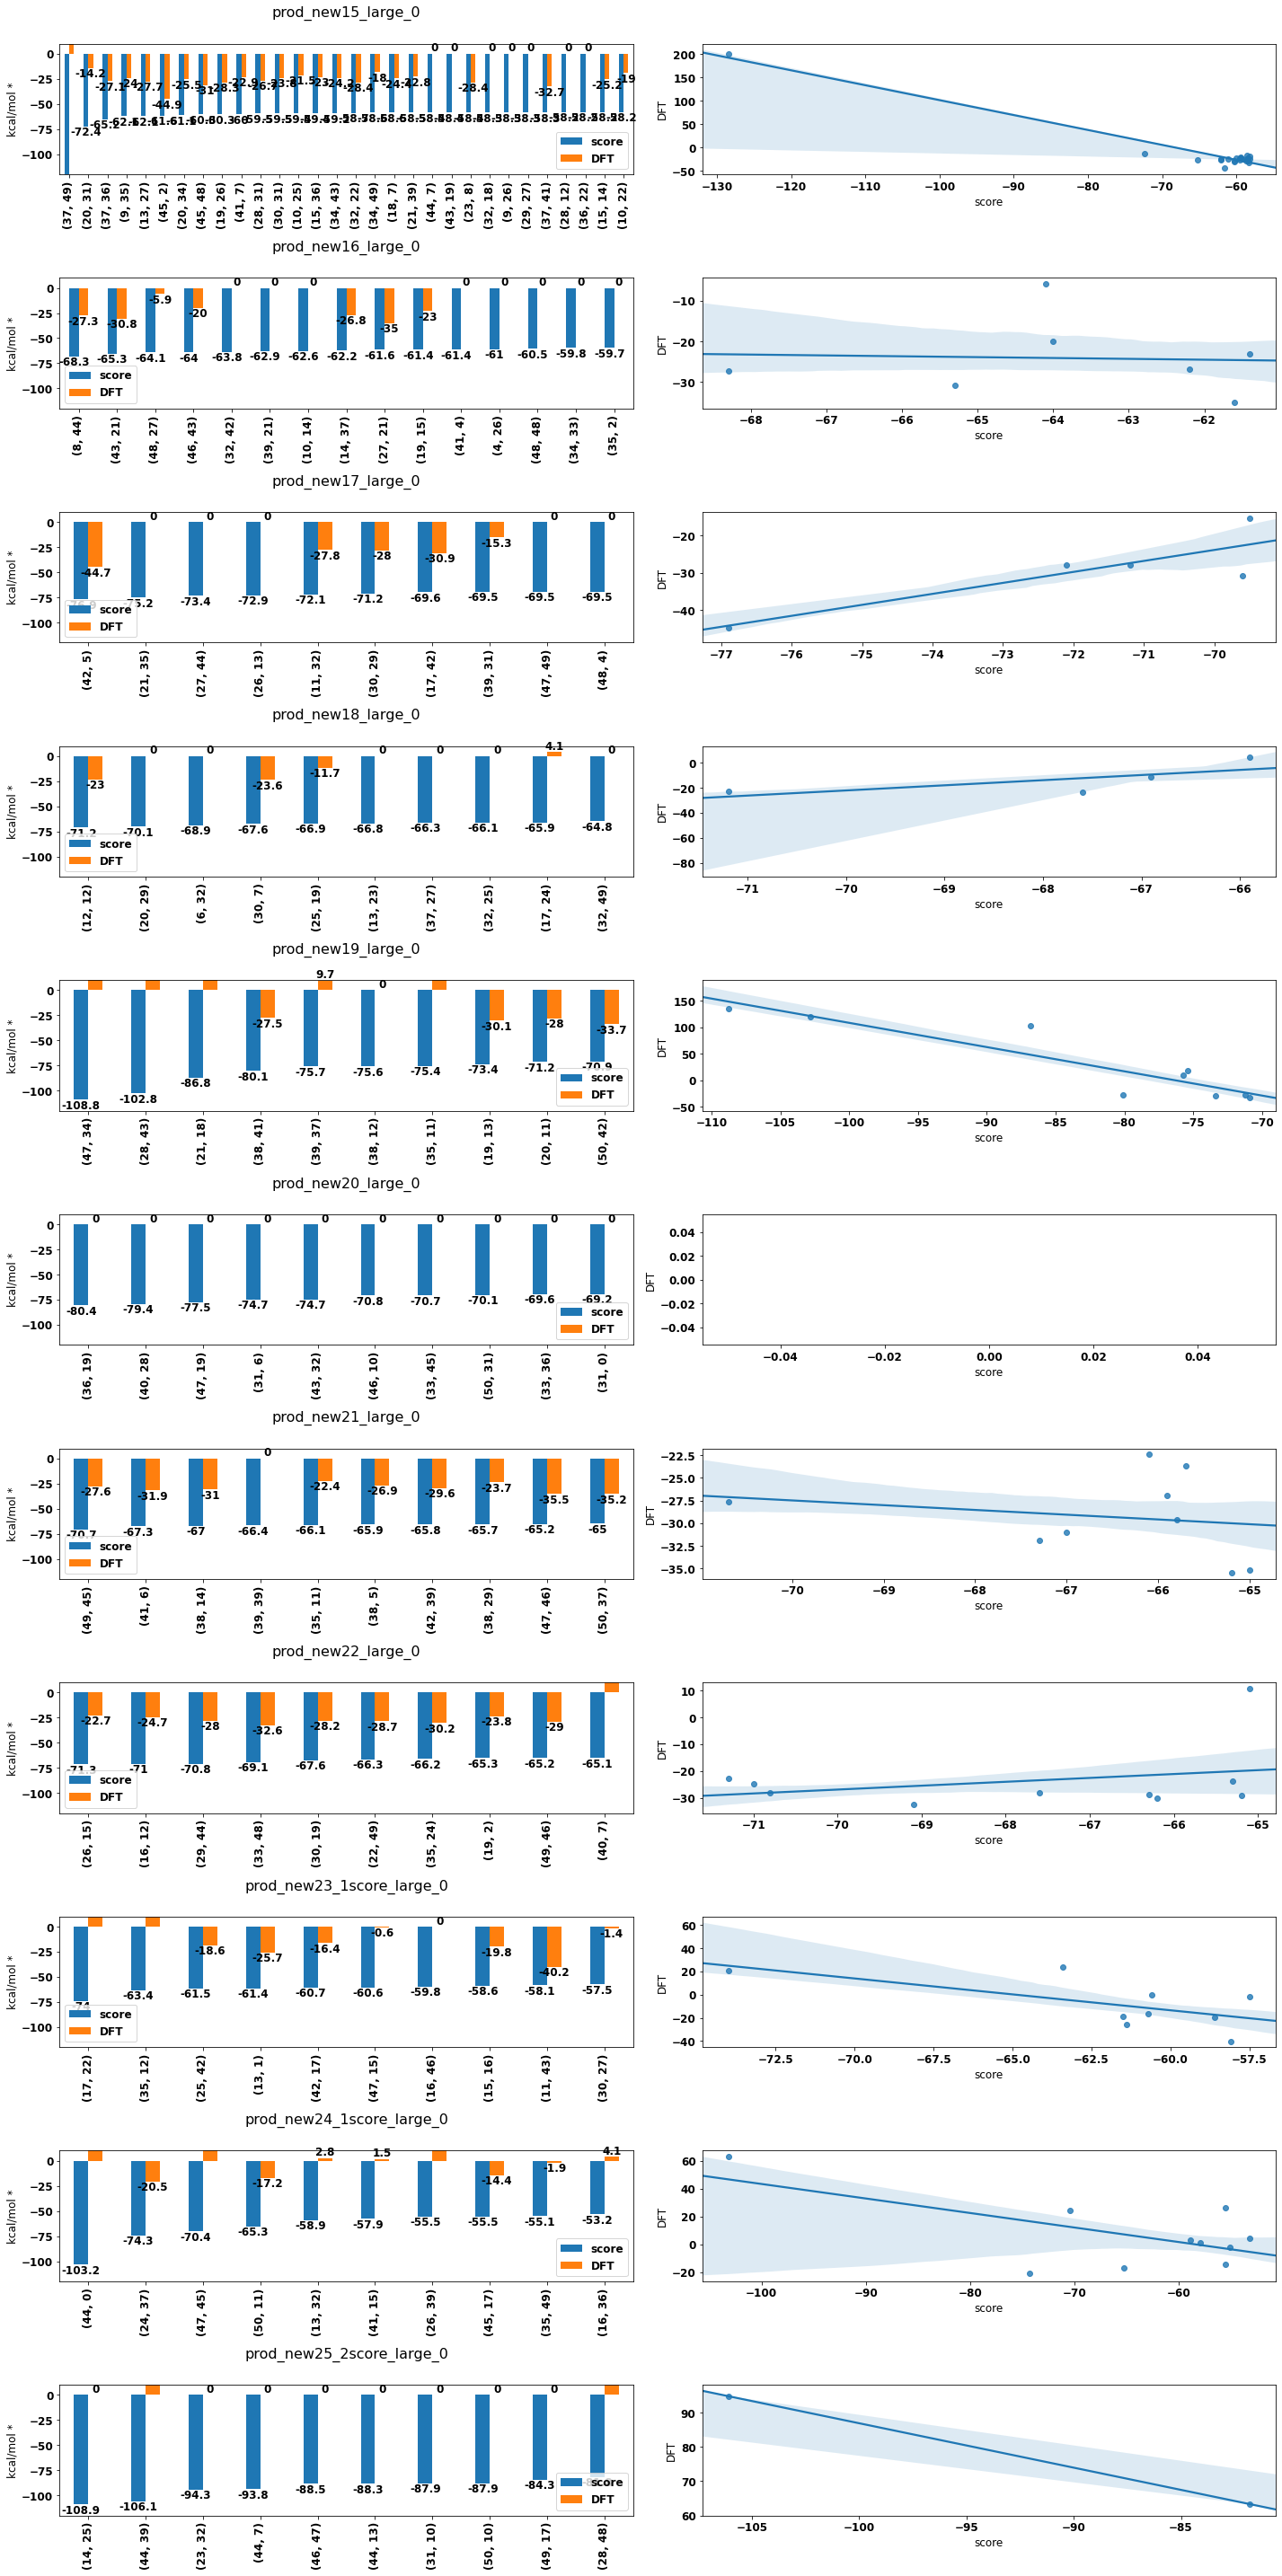

In [40]:
# Init figure
fig, ax = plt.subplots(nrows=num_plots,ncols=2,figsize=(20, 40));

for i,file in enumerate(logfiles):
    print(file)
    
    ax_i = ax[i,0]
    
    # Get the scoring funtion that was used
    if sorted(file.glob('*/Mo_NH3+')):
        scoring = 'rdkit_embed_scoring_NH3plustoNH3'
    elif sorted(file.glob('*/Mo_N2_NH3')):
        scoring = 'rdkit_embed_scoring'
    elif sorted(file.glob('*/Mo_N2')):
        scoring = 'rdkit_embed_scoring_NH3toN2'

        
    f = sorted(file.glob('*[!.csv]'))
    dataframe_path = f[0].parent /'df.csv'
    
    # Delete csv and redo scoring
    #if dataframe_path.is_file():
    #    dataframe_path.unlink()
    
    if dataframe_path.is_file():
        df = pd.read_csv(dataframe_path, index_col=[0,1])
    else:
        print(scoring)
        inds,deltas = funcs[scoring](f)
        
        gen = Generation(molecules=inds)
        df = gen.gen2pd()
        df['DFT'] = deltas
        df['score'] = df['score'].apply(lambda x: round(x, 1))
        df['DFT'] = df['DFT'].apply(lambda x: round(x, 1))
        df.sort_values(by=['score'], inplace=True)
        
        # Save DF
        df.to_csv(dataframe_path)
        
    df[['score','DFT']].plot.bar(ax=ax_i);
    ax_i.set(ylabel='kcal/mol *',ylim=(-120,10), xlabel='')
    ax_i.set_title(f[0].parent.name,fontsize = 16, pad=30)
    #ax.set_xticks([f'Molecule {x}' for x in range(5)])
    for container in ax_i.containers:
        ax_i.bar_label(container)
        
        
    # Plot corresponding correlation pplot
    sns.regplot(x="score", y="DFT",ci=68,truncate=False,data=df[df['DFT']!=0], ax=ax[i,1]);
    
    
# Magic
fig.tight_layout()

# Solution for comparing the different basis sets

# Correlation plot

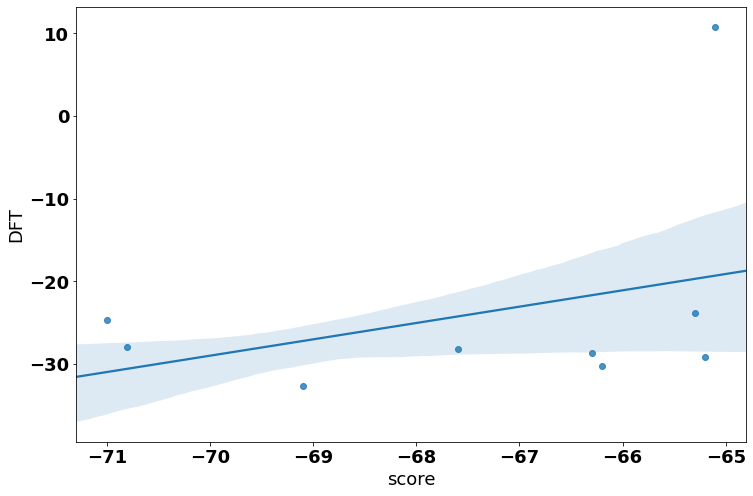

In [23]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.regplot(x="score", y="DFT",ci=68,truncate=False,data=df, ax=ax);